<a href="https://colab.research.google.com/github/ryerrabelli/BreastCancerClassification/blob/main/CICOM_Heme_Onc_Breast_Cancer_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Machine Learning with Python
This notebook will walk you through the use of a model that was built to detect invasive ductal carcinoma (IDC) from pathology images.  This model was built as a neural network that accepts a 3 channel RGB color image size of 50 x 50 pixel image at a resolution of around 4um/pixel, derived from this publication: [A Dataset for Breast Cancer Histopathological Image Classification](https://ieeexplore.ieee.org/document/7312934).  The publication has updated their source to this location as of 2020-10-26: [BreakHis Public Dataset](https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/)

This supervised neural net was modified based on a model developed by Adrian Rosenbrock, published on pyimagesearch.com [1](#REF).  trained on a dataset of approximately 55,000 images; containing images classified as cancer (class 1) and images classified as non-cancer/control (class 0).  The model was trained 5-6 times, and produced the following output statistics and confusion matrix for each run:
```
     precision    recall  f1-score   support
0       0.94      0.76      0.84     39612   
1       0.60      0.89      0.71     15893

micro avg       	0.80      0.80      0.80     55505
macro avg       	0.77      0.82      0.78     55505
weighted avg      0.85      0.80      0.81     55505

cm=
[[30068  9544]
[ 1756 14137]]

acc: 0.7964, sens: 0.7591, spec: 0.8895
```


Notice the averaged accuracy of ~79%.  This metric is only a high-level report on the model itself, due to the way the model was trained in batches.  For comparison: One study found that of H&E stained core biopsy samples from 874 patients with invasive ductal carcinoma, 800 were diagnosed from the initial core sample (91.5%).  Those statistics taken from PMC article: [Diagnostic accuracy of core biopsy for ductal carcinoma in situ and its implications for surgical practice](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1860430/).

Once the model was trained, the weighted parameters that comprise the model itself were saved out to ```.h5``` file.  The architecture of the model was saved to a ```.json```.

What we will do in this notebook is load the model structure and parameters so that we can run new images through the model.  This demonstrates how one could deploy a model once trained and validated.  It will also allow the model to test your acquired images so that you can evaluate the robustness of the model and get a better sense for how difficult a neural net might be to effectively deploy in practice.



In [ ]:
#@title Import Libraries
#@markdown We'll be using Keras on TensorFlow 1.x for this model. <br>
#@markdown You only have to run this once.
 
# load modules
# select which version of TF to use manually
%tensorflow_version 1.x 
import numpy as np
from matplotlib import pyplot as plt
from google.colab import files
import tensorflow as tf
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import sys
from PIL import Image
from IPython.display import display, Markdown, clear_output
 
# prevent keras from printing a bunch of config- warnings from shell
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')
from keras.models import model_from_json
sys.stderr = stderr
 
 
# on_load_file expects a string, ftype, designating which extension to load
def on_load_file(ftype, event=None):
    """Open file dialog to load file."""
    f_path = files.upload()
    for f in f_path.keys():
      if ftype in f:
        return f
        break
        
    print("Didn't find file of type: {}, please re-run.".format(ftype))
    return -1

In [ ]:
#@title Pull in trained model and images from Github
#@markdown We've trained the model for you, as it can be very time consuming to train. <br>
#@markdown We'll read in the model files and test images from a public repository here. 
 
all_files = ["test_imgs.zip\n", "model_weights.h5\n", "model_file.json\n"]
 
download_files = [f for f in os.listdir() if os.path.isfile(f)]
if "to_download.txt" in download_files:
    !rm "to_download.txt"
    print("resetting downloads...")
# find old files dont re download
with open("to_download.txt", "w") as to_get:
    for f in all_files:
        if f.strip('\n') in download_files:
            print(f"skipping {f.strip(os.linesep)}, exists in files...")
            continue
        else:
            to_get.write("https://raw.githubusercontent.com/ebbethke/cimed-hemeonc/main/"+f)
 
 
 
!wget -q -i to_download.txt
print("Files downloaded!")
 
if not os.path.isdir("test_imgs"):
    print("Unzipping test images to folder...")
    to_unzip = "test_imgs.zip"
    !unzip $to_unzip
    print("Unzipping complete!")

resetting downloads...
skipping test_imgs.zip, exists in files...
skipping model_weights.h5, exists in files...
skipping model_file.json, exists in files...
Files downloaded!


# How this model works
We've walked you through what the model is doing in the steps below.  The notebook will do all this for you, but you should understand what's actually going on at a conceptual level.  The goal is for you to understand roughly how the model works, what it might take to use/implement it, and how to evaluate its usefulness for the task at hand.


## Step 1: Load .json Model 

We provided you with a json file containing the architecture of the neural net that was trained ahead of time.  To train the net on 55,000 images took 65 minutes on a GPU virtual machine, or VM, with 16 vCPU cores, 1096 GPU cores, and 64GB of RAM.  There is no manual component to training the model; everything must be set up and configured ahead of time, and only once the training is complete can you test the model against new images.

That said, as the model is running you can monitor the training loss and accuracy to ensure the parameters are set correctly.  If the loss keeps increasing from epoch to epoch, it would be common to stop the training and adjust parameters.

## Step 2: Load the Node Weights

These weights and biases are numerical, and dictate the activation of each node for a given input.  In this case, the model accepts a 50 x 50 x 3 channel image, and 'learns' by associating each RGB pixel from a 50 x 50 image with a label of **cancer** or **not cancer**. As the model learns, it tweaks these numerical values at each node based on a cost function and activation function to improve the degree to which the output agrees with the label given.

## Step 3: Load Your Test Images

Now that the model is loaded, we can upload the images to test it against.  The model expects to recieve a folder structure as follows:
```
Folder:[ test_imgs ]
            |
       Folder:[   99999   ]
                  |     |     |   
                  img   img   img ...

```

**NOTE: The names of the folders and parts of the filenames are set up for you to make the model easier to run consistently**.  The names themselves aren't important, but please don't change the names of the folders or files unless you know what you're doing.

The images should be RGB ```.png``` files, and the whole folder was downloaded and unzipped for you above.  You can use the ```test_imgs``` folder provided to confirm and test.  

### Testing custom images
We've set up the code so that you can run this with your own acquired images that you can upload in the files tab.  You'll see we've uploaded 4 examples for you in the ```test_imgs/99999/``` folder you downloaded above.  If you want to test your own images, please adhere to the following rules:
1. Upload the images as png
2. Upload the images and move them to the ```99999``` folder inside ```test_imgs``` folder
3. Append ```_tc0``` to the image filenames you labeled as non-cancer/control, and append ```_tc1``` to images filenames you labeled as cancer.  The test script will look for those filenames to display your images separately.

**Warning: If you do not use the exact same file/folder convention as above for your folder, the model may not run.**

## Running the Model

The model now creates an image generator which will pre-process and run the images in the ```classes``` sub-folder of the ```TEST_PATH``` folder through the model.  The output of the model is a prediction array, ```[P(0) | X, P(1) | X]``` where ```P(0) | X``` is the predicted liklihood estimate that image ```X``` belongs to class 0, or non-cancer/control.  Predictions for this model will be $\in (0,1)$ for non-blank images. 


In [ ]:
#@title Run the Model.
#@markdown This code passes the images provided to the model using <br>
#@markdown an image generator function, scores the image (0,1) and returns <br>
#@markdown that value to a list structure we will use to evaluate our model. <br><br>
#@markdown You should see an output like: <br>
#@markdown ```Found 19 images belonging to 1 classes.``` <br>
#@markdown ```Prediction: 0, score: 0.004669214133173227``` <br> 
#@markdown ```Prediction: 1, score: 0.5614888668060303``` <br> 
#@markdown ```Prediction: 1, score: 0.9028431177139282``` <br>
#@markdown ``` .........```
 
 
# Time to make the donuts
# This script will load the images from the test_imgs folder and run them 
# through a generator that will pre-process the images for input into the 
# neural net.  When the neural net runs, it will activate the final output
# node with a float, (0.0, 1.0). If the output for that input is closer to 0,
# the model predicts the input image was of control/normal tissue.
# If closer to 1, the model predicts the input image contained features 
# consistent with invasive ductal carcinoma. 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
 
# suppress non-error TF output 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.logging.set_verbosity(tf.logging.ERROR)
# load model file
with open("model_file.json", 'r') as jmodel:
    json_string = jmodel.read()
model = model_from_json(json_string)
# load weights and biases
model.load_weights("model_weights.h5")
 
# set path to test images, and batch size
TEST_PATH = "test_imgs/"
BATCH = 32
 
# initialize the validation (and testing) data augmentation object
valAug = ImageDataGenerator(rescale=1 / 255.0)
 
# initialize the testing generator
testGen = valAug.flow_from_directory(
    TEST_PATH,
    classes=["99999"],
    class_mode="categorical",
    target_size=(48, 48),
    color_mode="rgb",
    shuffle=False,
    seed=42)
files = testGen.filenames
paths = testGen.filepaths
 
 
# use our trained model to make predictions on the data
predIdxs = model.predict(testGen)
 
# for each image in the testing set, we report the score and predicted class
for prediction in predIdxs:
    print("Prediction: {}, score: {}".format((1 if prediction[-1] > .5 else 0) , prediction[-1]))

Found 24 images belonging to 1 classes.
Prediction: 0, score: 0.15413205325603485
Prediction: 0, score: 0.34114181995391846
Prediction: 1, score: 0.9567980170249939
Prediction: 1, score: 0.9695548415184021
Prediction: 1, score: 0.9858142733573914
Prediction: 1, score: 0.5989706516265869
Prediction: 0, score: 0.13619288802146912
Prediction: 0, score: 0.1355980783700943
Prediction: 1, score: 0.866153359413147
Prediction: 1, score: 0.9061095118522644
Prediction: 1, score: 0.6600800156593323
Prediction: 0, score: 0.17191939055919647
Prediction: 1, score: 0.9339074492454529
Prediction: 0, score: 0.2953018248081207
Prediction: 1, score: 0.7979119420051575
Prediction: 0, score: 0.45995405316352844
Prediction: 0, score: 0.12372042238712311
Prediction: 0, score: 0.4678401052951813
Prediction: 1, score: 0.9044085144996643
Prediction: 0, score: 0.1597348004579544
Prediction: 1, score: 0.9319671392440796
Prediction: 1, score: 0.9624251127243042
Prediction: 0, score: 0.020104989409446716
Prediction

## Visualizing the Test Data

During training, we've reserved a proportion of the labeled images (typically 20-30%) for validation and testing.  The images in the ```test_imgs/99999``` folder are some of the reserved test images we did not use to train the model.  If you've loaded the ```test_imgs``` folder we provided and run it through the model, we can visualize images where the model got it right and wrong to help you understand where the model does well and where it might be error-prone. To do this, we'll use the labels provided to build a confusion matrix.  Confusion matrices provide information about where the model correctly predicted, and where it incorrectly predicted for each type of input.  An example is shown below:
<center>
<img src="https://miro.medium.com/max/1500/1*uq5OIjMM3lBO2IaqlKVefA.png" style="height: 500px"/> <div> Example of 6 dimensional confusion matrix from <a href="https://towardsdatascience.com/a-simple-cnn-multi-image-classifier-31c463324fa">This Article</a> by Iftekher Mamun.
</div>
</center>

The script will pick through  each type of image, and show you the results for the training data as well as your images.  Because we only have 2 classes, we can simplify this categorization to just four categories:
1. Predicted = 1, Actual = 1 (True Positive, TP)
2. Predicted = 1, Actual = 0 (False Positive, FP)
3. Predicted = 0, Actual = 0 (True Negative, TN)
4. Predicted = 0, Actual = 1 (False Negative, FN)

In the real world, you may want to define your own cost function for training the model so that certain types of errors are "punished" more. You can define cost functions in any way they can produce an optimization problem.  

In medicine, we typically assume a False Negative is more harmful than a False Positive, so we may adjust the cost function so that arrangement of predictions reflects the real world costs.  This all relates back to the ROC analysis as well; the CNN training is essentially trying to find an optimized function for a very high-dimensional ROC curve.

ValueError: ignored

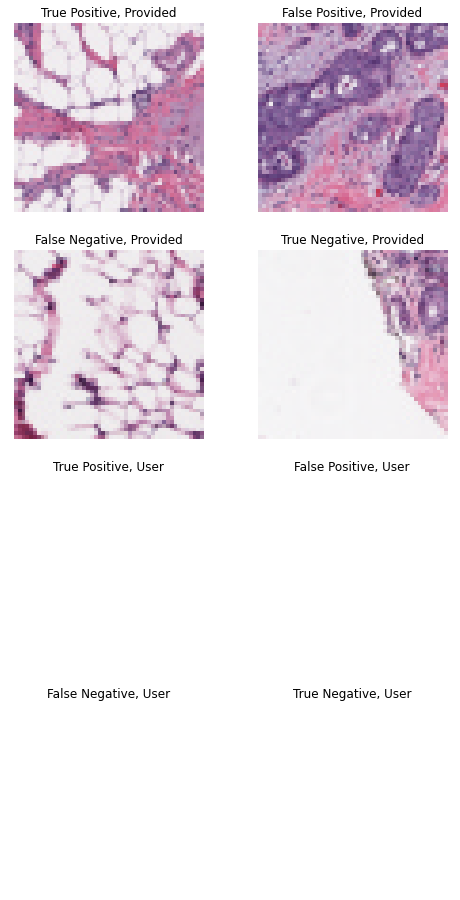

In [ ]:
#@title Test each image against the model
#@markdown Threshold is the cutoff for deciding if the image is cancer or not. <br>
#@markdown 0.5 is common and used above, but you may set it higher or lower.
threshold = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
 
# now what we'll do is rip through some test images again and determine which  
# were correctly and incorrectly classified, and display one of each:
# True positive, False positive, False negative, True negative.
try:
    directory = os.path.join(TEST_PATH + "99999/")
except NameError:
    raise("Please run the model above before visualizing the results!")
 
 
fig = plt.figure(1, figsize=(8,16))
 
f1 = fig.add_subplot(4,2,1)
f1.axis('off')
f1.title.set_text("True Positive, Provided")
 
f2 = fig.add_subplot(4,2,2)
f2.axis('off')
f2.title.set_text("False Positive, Provided")
 
f3 = fig.add_subplot(4,2,3)
f3.axis('off')
f3.title.set_text("False Negative, Provided")
 
f4 = fig.add_subplot(4,2,4)
f4.axis('off')
f4.title.set_text("True Negative, Provided")
 
g1 = fig.add_subplot(4,2,5)
g1.axis('off')
g1.title.set_text("True Positive, User")
 
g2 = fig.add_subplot(4,2,6)
g2.axis('off')
g2.title.set_text("False Positive, User")
 
g3 = fig.add_subplot(4,2,7)
g3.axis('off')
g3.title.set_text("False Negative, User")
 
g4 = fig.add_subplot(4,2,8)
g4.axis('off')
g4.title.set_text("True Negative, User")
 
# examples from povided test classes
TP = []
TN = []
FP = []
FN = []
 
TPt = []
TNt = []
FPt = []
FNt = []
 
model_scores = [1 if score > threshold else 0 for lbl,score in predIdxs]
 
for idx,filename in enumerate(paths):
    if filename.endswith(".png"): 
        if model_scores[idx] == 1:
            if 'class' in filename:
              TP.append(filename) if 'class1' in filename else FP.append(filename)
            elif '_tc' in filename:
              TPt.append(filename) if 'tc1' in filename else FPt.append(filename)
        else:
            if 'class' in filename:
              FN.append(filename) if 'class1' in filename else TN.append(filename)
            elif '_tc' in filename:
              FNt.append(filename) if 'tc1' in filename else TNt.append(filename)
    else:
        continue
 
# Plot provided test image model prediction results
provided_res = list(zip([f1,f2,f3,f4], [TP, FP, FN, TN]))
for category in provided_res:
    try:
        sel = np.random.choice(category[1])
    except ValueError:
        continue
    img = plt.imread(sel)
    category[0].imshow(img)
 
# plot user provided test image results
user_res = list(zip([g1,g2,g3,g4], [TPt, FPt, FNt, TNt]))
for category in user_res:
    try:
      sel = np.random.choice(category[1])
    except ValueError:
      continue
    img = plt.imread(sel)
    category[0].imshow(img, 0)
 
sep = plt.plot([0, 1],[0.51, 0.51], color='k', lw=5,transform=plt.gcf().transFigure, clip_on=False)

## Results

If one of the above four are empty, it means the model didn't find one for that category.  You can re-run the previous script to generate new random selections of the outputs as they were categorized. 

In [ ]:
!pwd
 
!mv Tissue2_tc0.png /content/test_imgs/99999

/content


In [ ]:
# Run this cell to get a readout of how all files got classified.
# You can then check them out and try and figure out if the model has any
# obvious strengths or weaknesses with regards to input image.
 
 
print("Provided Images, False Positive: {}".format(FP))
print("Provided Images, False Negative: {}".format(FN))
print("Provided Images, True Positive: {}".format(TP))
print("Provided Images, True Negative: {}".format(TN))
 
print("Your Images, False Positive: {}".format(FPt))
print("Your Images, False Negative: {}".format(FNt))
print("Your Images, True Positive: {}".format(TPt))
print("Your Images, True Negative: {}".format(TNt))

Provided Images, False Positive: ['test_imgs/99999/8974_idx5_x151_y1901_class0.png', 'test_imgs/99999/8974_idx5_x251_y1201_class0.png', 'test_imgs/99999/8974_idx5_x751_y1801_class0.png']
Provided Images, False Negative: ['test_imgs/99999/8864_idx5_x1451_y2801_class1.png', 'test_imgs/99999/8864_idx5_x1551_y2501_class1.png']
Provided Images, True Positive: ['test_imgs/99999/8864_idx5_x1551_y2701_class1.png', 'test_imgs/99999/8864_idx5_x1551_y2751_class1.png', 'test_imgs/99999/8864_idx5_x1751_y2701_class1.png', 'test_imgs/99999/8864_idx5_x1801_y2101_class1.png', 'test_imgs/99999/8865_idx5_x1701_y651_class1.png', 'test_imgs/99999/8865_idx5_x1701_y701_class1.png', 'test_imgs/99999/8865_idx5_x1951_y601_class1.png']
Provided Images, True Negative: ['test_imgs/99999/8865_idx5_x101_y1001_class0.png', 'test_imgs/99999/8865_idx5_x101_y1051_class0.png', 'test_imgs/99999/8865_idx5_x551_y1401_class0.png', 'test_imgs/99999/8974_idx5_x151_y2001_class0.png', 'test_imgs/99999/8974_idx5_x251_y1251_class0

#REF

Rosebrock, Adrian. “Breast Cancer Classification with Keras and Deep Learning.” PyImageSearch, 23 Apr. 2019, https://www.pyimagesearch.com/2019/02/18/breast-cancer-classification-with-keras-and-deep-learning/.